In [1]:
import pandas as pd
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sim_utils.modeling import update_config

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [3]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [32]:
opp.loc[opp.opponent_team=='KC'].head(2)

,opponent_team,season,week,completions_opp_roll,attempts_opp_roll,carries_opp_roll,passing_yards_opp_roll,rushing_yards_opp_roll,pass_pct_opp_roll,receiving_yards_opp_roll,yards_per_carry_opp_roll
11,KC,2000,1,1.064764,0.957898,1.190031,1.162456,1.049627,0.904024,1.162451,0.885603
64,KC,2000,2,1.088963,1.017766,1.134248,1.124133,1.058447,0.952702,1.124129,0.936965


In [14]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['team','season','week']).drop('team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)

rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [15]:
pbp.loc[(pbp.week==12)
        & (pbp.season==2024)
        & (pbp.away_team=='KC')]

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,pass_pct_team_roll,receiving_yards_team_roll,completions_opp_roll,attempts_opp_roll,carries_opp_roll,passing_yards_opp_roll,rushing_yards_opp_roll,pass_pct_opp_roll,receiving_yards_opp_roll,yards_per_carry_opp_roll
1041748,40.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041749,63.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041750,85.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041751,107.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041752,133.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041915,4416.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041916,4443.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041917,4482.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021
1041918,4514.0,2024_12_KC_CAR,2024112400,CAR,KC,REG,12,KC,away,CAR,...,1.025776,1.075575,1.078592,0.979279,1.312222,1.064520,1.475526,0.869659,1.064516,1.129021


In [16]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team', 'week', 'gsis_id', 
       'position', 'player_display_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
)
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll', 'yards_per_carry_roll', 'rushing_tds_roll','rushing_first_downs_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll','rushing_tds_roll','rushing_first_downs_roll']].fillna(0)

rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)
len(rushes)

158119

In [17]:
game_context_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    #'quarter_seconds_remaining',
    #'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
team_rush_cols = [
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [18]:
rush_yards_cols = game_context_cols + rusher_stat_cols + team_rush_cols
rush_yards_cols

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'yards_per_carry_roll',
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [19]:
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [20]:
rushes[rush_yards_cols].isna().sum()

yardline_100                   0
down                           0
goal_to_go                     0
ydstogo                        0
posteam_score                  0
defteam_score                  0
score_differential             0
game_seconds_remaining         0
wind                       52686
temp                       52686
spread_line                    0
total_line                     0
carries_roll                   0
rushing_yards_roll             0
yards_per_carry_roll           0
rushing_yards_team_roll        0
rushing_yards_opp_roll         0
dtype: int64

In [21]:
import torch
import torch.nn as nn

class masked_model(nn.Module):
    def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.):
        super(masked_model, self).__init__()
        self.n_out=n_out
        self.main_layers = nn.Sequential(
        nn.Linear(n_in, n_hidden),nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        )
        self.add_yardline = nn.Linear(n_hidden + 1, n_out)
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]

        x = self.main_layers(x)
        x = torch.cat((x, feature_to_pass), dim=1) 
        x = self.add_yardline(x)



        end_zone = feature_to_pass[:,0].clone().detach().view(-1)
        accum_mask = torch.nn.functional.one_hot(end_zone.type(torch.LongTensor)+30, self.n_out)
        accum_mask =  accum_mask +  torch.sum(accum_mask, dim=1, keepdims=True) - torch.cumsum(accum_mask, dim=1)
        accum_mask = accum_mask.type(torch.bool)
        x = x.masked_fill(~accum_mask, float('-1000'))

        return x


In [24]:
cat_columns = [
 'down',
 'goal_to_go',

]
cont_columns = [
  'yardline_100',
 'ydstogo',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'yards_per_carry_roll',
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll'
]


In [25]:
len(cont_columns)

15

In [26]:
X = rushes[rush_yards_cols]
y = rushes['yards_shifted']
obs = len(X)
num_feats = len(rush_yards_cols)


In [27]:
X_cat = torch.tensor(X[cat_columns].values, dtype=torch.int32)
X_cont = torch.tensor(X[cont_columns].values, dtype=torch.float32)

def get_sample(num_samples):
    idx = np.random.randint(0,len(X_cat), num_samples)
    return (X_cat[idx], X_cont[idx])

get_sample(2)

(tensor([[3, 0],
         [1, 0]], dtype=torch.int32),
 tensor([[ 6.6000e+01,  1.0000e+00,  3.0000e+00,  7.0000e+00, -4.0000e+00,
           2.6660e+03,  7.0000e+00,  5.9000e+01,  1.0000e+00,  4.8000e+01,
           1.6763e+01,  6.3891e+01,  3.7658e+00,  7.9207e-01,  9.4000e-01],
         [ 7.5000e+01,  1.0000e+01,  2.4000e+01,  1.7000e+01,  7.0000e+00,
           3.2500e+02,         nan,         nan, -2.0000e+00,  4.6500e+01,
           1.0506e+01,  5.3339e+01,  4.8964e+00,  9.7592e-01,  8.8330e-01]]))

In [28]:
c,n = get_sample(550)

In [31]:
model = masked_model(
    n_in=15,
    n_out=130,
    n_hidden=64,
    dropout_prob=0.
).to('cuda')
            # numerical value
c,n = get_sample(550)
print(c.shape, n.shape)
pred = model(c.to('cuda'),n.to('cuda'))
pred

torch.Size([550, 2]) torch.Size([550, 15])


TypeError: masked_model.forward() takes 2 positional arguments but 3 were given

In [ ]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y = torch.tensor(y,dtype=torch.long).to(device)
    # Define the model, loss function, and optimizer

    X_cat = torch.tensor(X[cat_columns].values, dtype=torch.int32).to(device)
    X_cont = torch.tensor(X[cont_columns].values, dtype=torch.float32).to(device)
    model = FTTransformer(
        categories = (4, 2),      # tuple containing the number of unique values within each category
        num_continuous = 15,                # number of continuous values
        dim = 32,                           # dimension, paper set at 32
        dim_out = 130,                        # binary prediction, but could be anything
        depth = 6,                          # depth, paper recommended 6
        heads = 8,                          # heads, paper recommends 8
        attn_dropout = 0.1,                 # post-attention dropout
        ff_dropout = 0.1                    # feed forward dropout
    ).to(device)
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

    num_samples = X_cat.size(0)
    indices = torch.randperm(num_samples, device=device)

    # Calculate train-test split sizes
    split = num_samples // 5  # 20% test data
    test_indices = indices[:split]
    train_indices = indices[split:]

    # Create train-test splits using the shuffled indices

    Xtr_cat, Xtr_cont = X_cat[train_indices].to(device), X_cont[train_indices].to(device)
    Xtst_cat, Xtst_cont = X_cat[test_indices].to(device), X_cont[test_indices].to(device)
    train_y = y[train_indices].to(device)
    test_y =  y[test_indices].to(device)

    # Training loop
    epochs = epochs
    batch_size = 64

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(Xtr_cat.size(0))
        epoch_loss = 0

        for i in range(0, Xtr_cat.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x_cat,batch_x_cont, batch_y = Xtr_cat[indices], Xtr_cont[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_x_cat, batch_x_cont)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(Xtr_cat):.4f}")

        # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(Xtst_cat, Xtst_cont)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item() 
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
    samples = torch.clamp( torch.multinomial(test_preds,100,replacement=True),max=76) - 30
    avg = round(samples.double().mean().item(), 3)
    plt.hist(test_preds, alpha=0.5, color='r')
    plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
    return model

Epoch 1/10, Loss: 0.0240
Epoch 2/10, Loss: 0.0230
Epoch 3/10, Loss: 0.0230
Epoch 4/10, Loss: 0.0230
Epoch 5/10, Loss: 0.0230
Epoch 6/10, Loss: 0.0230
Epoch 7/10, Loss: 0.0230
Epoch 8/10, Loss: 0.0230
Epoch 9/10, Loss: 0.0230
Epoch 10/10, Loss: 0.0230
Test Loss: 2.9379, Test Accuracy: 0.1279


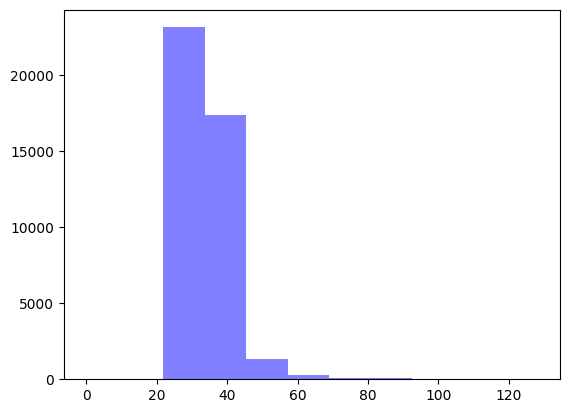

In [ ]:
rush_yards_model = train_model(X,y, 17, 130, n_hidden = 1024, epochs=10) # 2.937 loss, 0.1279 acc

In [ ]:
def sample_df(df, num_samples):
    device = 'cuda'
    test = df.copy()
    x_cat = torch.tensor(test.sample(num_samples, replace=True)[cat_columns].astype(int).values, dtype=torch.int32).to(device).reshape(num_samples,-1)
    x_cont = torch.tensor(test.sample(num_samples, replace=True)[cont_columns].astype(float).values, dtype=torch.float32).to(device).reshape(num_samples,-1)
    out = rush_yards_model(x_cat, x_cont)
    return x_cont, out.to('cuda')

In [ ]:
xx, res = sample_df(rushes.loc[rushes.yardline_100 < 10], 10)

In [ ]:
ydl_shift

tensor([38., 38., 34., 33., 33., 33., 38., 31., 32., 38.], device='cuda:0')

In [ ]:
ydl_shift = xx[:,0] + 30
res

tensor([[-0.6922, -0.6922, -0.6927,  ..., -0.6878, -0.6921, -0.6879],
        [-0.6922, -0.6922, -0.6927,  ..., -0.6878, -0.6921, -0.6879],
        [-0.6922, -0.6922, -0.6927,  ..., -0.6878, -0.6921, -0.6879],
        ...,
        [-0.6922, -0.6922, -0.6927,  ..., -0.6878, -0.6921, -0.6879],
        [-0.6922, -0.6922, -0.6927,  ..., -0.6878, -0.6921, -0.6879],
        [-0.6922, -0.6922, -0.6927,  ..., -0.6878, -0.6921, -0.6879]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

<Axes: >

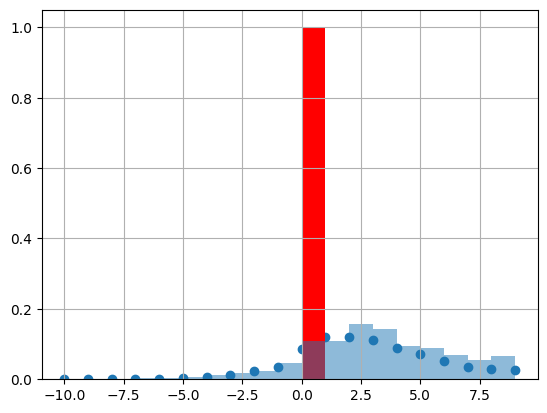

In [ ]:
ydl = 10
test = rushes.loc[rushes.yardline_100==ydl, rush_yards_cols].copy()
testy = rushes.loc[rushes.yardline_100==ydl, 'yards_shifted'].copy()




a = sample_df(test, 30).mean(dim=0)
a = torch.nn.functional.softmax(a,dim=0)
#a[30+ydl] = a[30+ydl+1:].sum()
#a[30+ydl+1:] /= 20
a.shape
a = a.detach().to('cpu')
plt.scatter(range(-10,10),a[20:40])
plt.hist(a, bins=range(-10,10),density=True, color='r')
(testy-30).hist(density=True, alpha=0.5, bins=range(-10,10))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  2.,  4.,  3.,  9.,  9., 12.,  9.,  9., 17.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

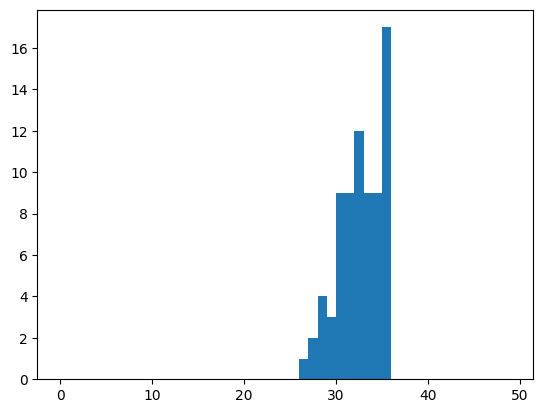

In [ ]:
plt.hist(testy, bins = range(0, 50, 1))

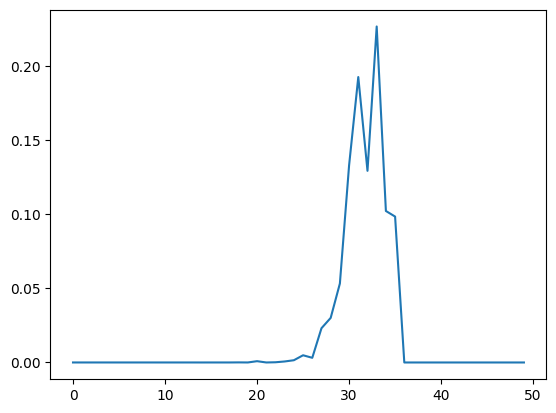

In [ ]:
plt.plot(out.detach()[0:50])

In [ ]:
rush_yards_model = rush_yards_model.to('cpu')

In [ ]:
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

update_config(feature_config)

In [ ]:
test = rushes.loc[rushes.yardline_100==5][rush_yards_cols+ ['yards_shifted']]
test

,yardline_100,down,goal_to_go,ydstogo,posteam_score,defteam_score,score_differential,game_seconds_remaining,wind,temp,spread_line,total_line,carries_roll,rushing_yards_roll,yards_per_carry_roll,rushing_yards_team_roll,rushing_yards_opp_roll,yards_shifted
166,5.0,3.0,0,4.0,0.0,0.0,0.0,2969.0,10.0,64.0,5.5,40.5,0.000000,0.000000,0.000000,0.794630,0.794759,32.0
307,5.0,2.0,0,4.0,17.0,14.0,3.0,190.0,6.0,87.0,-2.5,37.0,0.000000,0.000000,0.000000,1.062483,1.062655,33.0
416,5.0,2.0,1,5.0,0.0,0.0,0.0,3332.0,10.0,75.0,-6.5,44.5,0.000000,0.000000,0.000000,0.901771,0.901918,34.0
740,5.0,2.0,1,5.0,0.0,0.0,0.0,2860.0,10.0,78.0,-4.0,45.5,0.000000,0.000000,0.000000,0.973198,0.973357,32.0
1013,5.0,2.0,0,4.0,7.0,10.0,-3.0,2414.0,5.0,58.0,-7.0,41.0,8.000000,39.000000,4.875000,0.620526,0.250037,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211900,5.0,2.0,0,4.0,9.0,20.0,-11.0,1426.0,5.0,61.0,11.0,43.0,18.797095,92.528914,4.922511,0.957892,0.691428,33.0
212118,5.0,1.0,1,5.0,10.0,6.0,4.0,827.0,13.0,36.0,3.5,36.5,13.594059,71.648165,5.270550,0.621163,0.824100,33.0
212124,5.0,1.0,1,5.0,6.0,18.0,-12.0,509.0,13.0,36.0,-3.5,36.5,2.380535,9.888008,4.153692,1.241051,0.929983,28.0
212154,5.0,2.0,0,2.0,10.0,0.0,10.0,2235.0,11.0,43.0,-6.5,44.5,17.274053,84.816442,4.910049,1.237225,0.848338,34.0


torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])
torch.Size([1, 17])


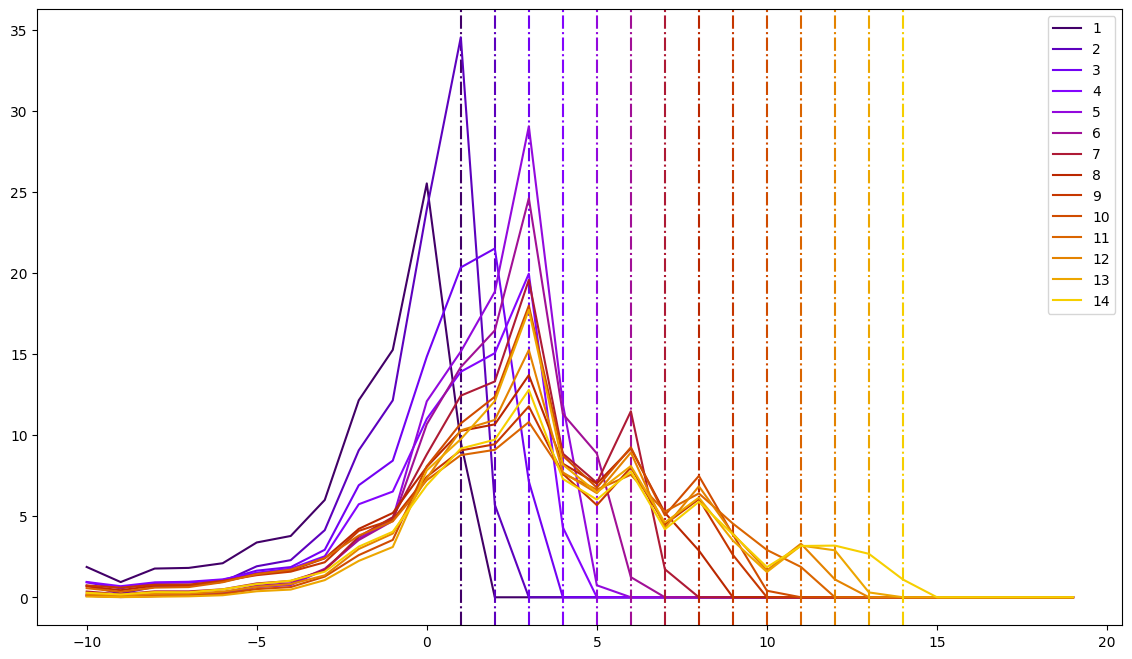

In [ ]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 15
for yardline in range(1,num_yardlines):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = rushes.loc[rushes.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy[:,30+yardline:] /= 2
        xy = (100 * F.softmax(xy,dim=1))[0]
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)
    plt.legend()

In [ ]:
test = rushes.loc[rushes.yardline_100==45].sample(1)
xx = torch.Tensor(test[rush_yards_cols].values)
xy = torch.Tensor(test['yards_shifted'].values)

5.907


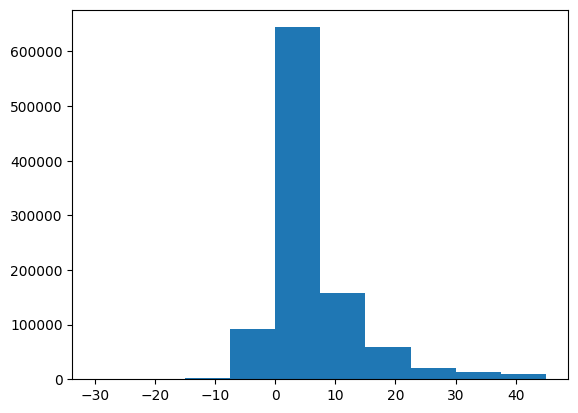

In [ ]:
res = rush_yards_model(xx)
res = F.softmax(res,dim=1)[0]
samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=76) - 30
avg = round(samples.double().mean().item(), 3)
plt.hist(samples)
print(avg)

In [ ]:
test.iloc[0][rush_yards_cols]

yardline_100                    45.0
down                             1.0
goal_to_go                         0
ydstogo                         10.0
posteam_score                   10.0
defteam_score                   16.0
score_differential              -6.0
game_seconds_remaining         501.0
wind                             5.0
temp                            60.0
spread_line                     -4.0
total_line                      42.5
carries_roll               15.217399
rushing_yards_roll          80.22121
yards_per_carry_roll        5.271677
rushing_yards_team_roll     0.781875
rushing_yards_opp_roll      0.483489
Name: 128423, dtype: object

In [ ]:
test = rushes.sample(1000)
xx = torch.Tensor(test[rush_yards_cols].values)
xy = torch.Tensor(test['yards_shifted'].values)
norm = xx.mean(dim=0).reshape(1,-1)
norm

tensor([[ 5.0546e+01,  1.6090e+00,  8.0000e-02,  8.0960e+00,  1.1395e+01,
          1.0474e+01,  9.2100e-01,  1.7715e+03,  7.9610e+00,  5.8434e+01,
         -2.9950e-01,  4.5019e+01,  1.0655e+01,  4.6563e+01,  4.2330e+00,
          1.0372e+00,  1.0311e+00]])

In [ ]:
from sim_utils.modeling import create_reg_model


In [ ]:
rushes['yards_shifted'] = rushes['yards_shifted'].astype(int)

In [ ]:
xg_model = create_reg_model(rushes, rush_yards_cols,'yards_gained' )

Mean Squared Error: 39.39766311645508
R-squared: 0.03164935111999512


In [ ]:
q = rushes.groupby('yardline_100')['yards_gained'].quantile([0.1,0.5,0.9]).reset_index(name=('quantile'))
q.loc[q.yardline_100 == 20]

,yardline_100,level_1,quantile
57,20.0,0.1,-1.0
58,20.0,0.5,3.0
59,20.0,0.9,11.0


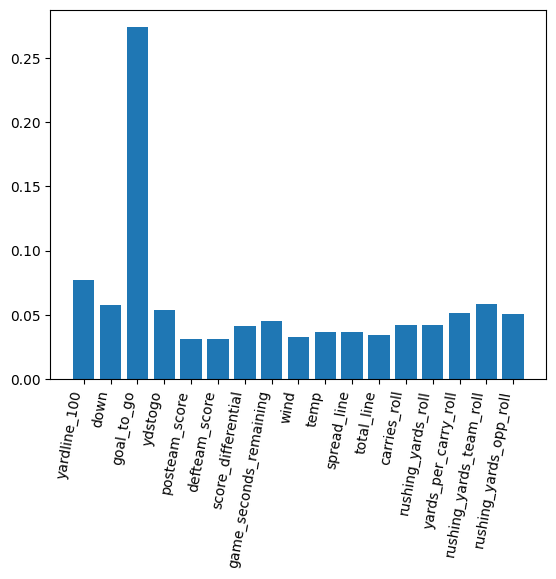

In [ ]:
from matplotlib import pyplot
bars = xg_model.get_booster().feature_names
y_pos = np.arange(len(bars))
pyplot.bar(range(len(xg_model.feature_importances_)), xg_model.feature_importances_)
pyplot.xticks(y_pos, xg_model.get_booster().feature_names, color='black', rotation=80, fontsize='10', horizontalalignment='right')
pyplot.show()

spread: 0.5 4.756
spread: 0.6 4.763
spread: 0.7 4.756
spread: 0.8 4.76
spread: 0.9 4.75
spread: 1.0 4.761
spread: 1.1 4.763
spread: 1.2 4.762
spread: 1.3 4.75
spread: 1.4 4.761


(array([  1166.,   1282.,   2992., 273382., 599318.,  79220.,  21343.,
          6254.,   3294.,  11749.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <BarContainer object of 10 artists>)

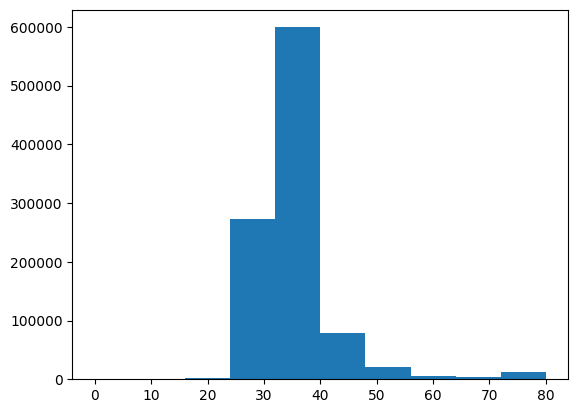

In [ ]:
norm = xx.mean(dim=0).reshape(1,-1) 

for ypc in range(5, 15, 1):
#for ypc in [0,1,10,100,1000]:
    ypc = ypc/10
    norm[0][-1] = torch.tensor(ypc)
    res = rush_yards_model(norm)
    #res[:,75:] -= 4
    res = F.softmax(res,dim=1)[0]
    samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=80)
    avg = round(samples.double().mean().item()-30, 3)
    print(f'spread: {ypc}',avg) # 3.34
plt.hist(samples)

In [ ]:
samples.double().min()

tensor(0., dtype=torch.float64)

<Axes: >

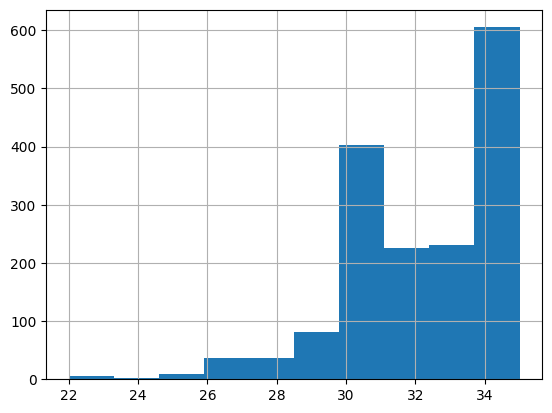

In [ ]:
rushes.loc[rushes.yardline_100==5]['yards_shifted'].hist()

In [ ]:
passes = pbp.loc[
        (pbp['pass']==1) & 
    (pbp.pass_attempt==1) & 
    (pbp.air_yards >= -20)
    & (pbp.play_type=='pass')
].copy(deep=True).dropna(axis=1,how='all')

In [ ]:
receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[[
    "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
]]

In [ ]:
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", "gsis_id"],
)
passes


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receiving_yards_roll,receiving_tds_roll,receiving_air_yards_roll,receiving_yards_after_catch_roll,receiving_first_downs_roll,target_share_roll,air_yards_share_roll,fantasy_points_ppr_roll,yards_per_target_roll,yards_per_catch_roll
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275457,3812.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,38.103053,0.011593,47.612262,14.928183,1.793535,0.171688,0.184008,7.404114,6.947856,10.810116
275458,3869.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,29.855179,0.083781,-1.337273,31.721545,1.191506,0.109480,-0.010025,24.402885,8.692839,15.046364
275459,3894.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,29.855179,0.083781,-1.337273,31.721545,1.191506,0.109480,-0.010025,24.402885,8.692839,15.046364
275460,3953.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,9.210293,0.000000,10.228033,7.625124,0.425586,0.057827,0.035774,2.089030,5.034367,7.885517


In [ ]:
passes = passes.loc[~passes.receptions_roll.isna()].copy()
#51456 

In [ ]:
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [ ]:
air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
] + game_context_cols + ['passing_yards_opp_roll']

In [ ]:
passes['target_share_roll'].isna().sum()

119

In [ ]:
passes['air_yards_20'] = passes['air_yards'] + 20
data = passes[air_yards_cols + ['air_yards_20']].copy()
data = data.dropna()
X = torch.Tensor((data[air_yards_cols].values))
y = torch.tensor(data['air_yards_20'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

torch.Size([267818])

Epoch 1/20, Loss: 0.0079
Epoch 2/20, Loss: 0.0068
Epoch 3/20, Loss: 0.0068
Epoch 4/20, Loss: 0.0068
Epoch 5/20, Loss: 0.0068
Epoch 6/20, Loss: 0.0068
Epoch 7/20, Loss: 0.0068
Epoch 8/20, Loss: 0.0068
Epoch 9/20, Loss: 0.0068
Epoch 10/20, Loss: 0.0068
Epoch 11/20, Loss: 0.0068
Epoch 12/20, Loss: 0.0068
Epoch 13/20, Loss: 0.0068
Epoch 14/20, Loss: 0.0068
Epoch 15/20, Loss: 0.0068
Epoch 16/20, Loss: 0.0068
Epoch 17/20, Loss: 0.0068
Epoch 18/20, Loss: 0.0068
Epoch 19/20, Loss: 0.0068
Epoch 20/20, Loss: 0.0068
Test Loss: 3.4504, Test Accuracy: 0.0867


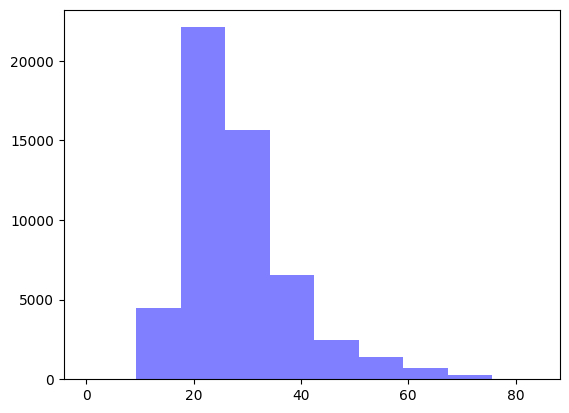

In [ ]:
air_yards_model = train_model(X, y, num_feats, 119) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')

In [ ]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
    'air_yards_cols':air_yards_cols,
    'air_yards_model_path': 'models/air_yards.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

11.272468


<Axes: >

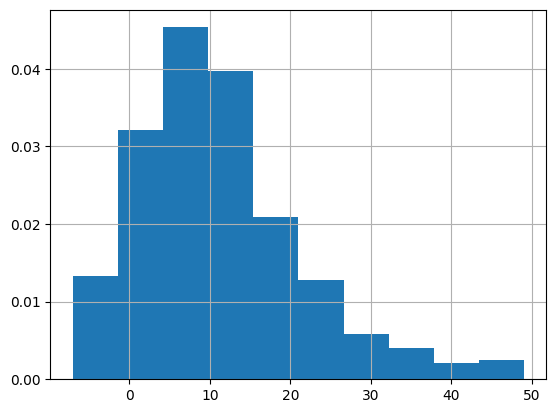

In [ ]:
jj = passes.loc[passes.receiver_player_id == '00-0036322']
print(jj['air_yards'].mean())
jj['air_yards'].hist(density=True)


tensor(11.4426, dtype=torch.float64)


(array([0.00017272, 0.00639656, 0.04617591, 0.03132807, 0.00898696,
        0.00394516, 0.00198364, 0.0004293 , 0.00015712, 0.00042455]),
 array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <BarContainer object of 10 artists>)

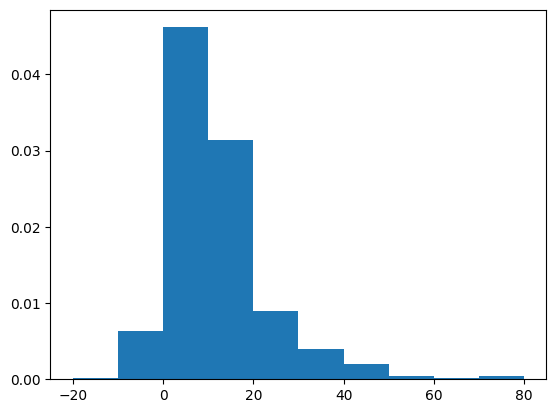

In [ ]:
test_x = torch.Tensor(jj[air_yards_cols].values)
res = air_yards_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp( torch.multinomial(res,10000,replacement=True),max=100).reshape(-1) - 20
print(samples.double().mean())
plt.hist(samples,density=True)

In [ ]:
passes[['yardline_100','yards_gained','air_yards','yards_after_catch', 'complete_pass']]

,yardline_100,yards_gained,air_yards,yards_after_catch,complete_pass
109,54.0,13.0,9.0,4.0,1.0
116,72.0,23.0,20.0,3.0,1.0
141,74.0,3.0,3.0,0.0,1.0
1086,20.0,0.0,6.0,NaN,0.0
1087,7.0,7.0,3.0,4.0,1.0
...,...,...,...,...,...
275457,49.0,16.0,16.0,0.0,1.0
275458,38.0,7.0,-3.0,10.0,1.0
275459,31.0,20.0,0.0,20.0,1.0
275460,21.0,11.0,-4.0,15.0,1.0


In [ ]:
completions = passes.loc[passes.complete_pass==1].copy()
completions['yac_25'] = completions['yards_after_catch'] + 25

In [ ]:
yac_cols = air_yards_cols + ['air_yards']
data = completions[yac_cols + ['yac_25']].copy()
data = data.dropna()
X = torch.Tensor((data[yac_cols].values))
y = torch.tensor(data['yac_25'].astype(int).values, dtype=torch.long)
obs = len(X)
air_yards_input = len(yac_cols)
X.shape

torch.Size([173144, 29])

Epoch 1/20, Loss: 0.0072
Epoch 2/20, Loss: 0.0054
Epoch 3/20, Loss: 0.0054
Epoch 4/20, Loss: 0.0054
Epoch 5/20, Loss: 0.0054
Epoch 6/20, Loss: 0.0054
Epoch 7/20, Loss: 0.0054
Epoch 8/20, Loss: 0.0054
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0054
Epoch 12/20, Loss: 0.0054
Epoch 13/20, Loss: 0.0054
Epoch 14/20, Loss: 0.0054
Epoch 15/20, Loss: 0.0054
Epoch 16/20, Loss: 0.0054
Epoch 17/20, Loss: 0.0054
Epoch 18/20, Loss: 0.0054
Epoch 19/20, Loss: 0.0054
Epoch 20/20, Loss: 0.0054
Test Loss: 2.7605, Test Accuracy: 0.2382


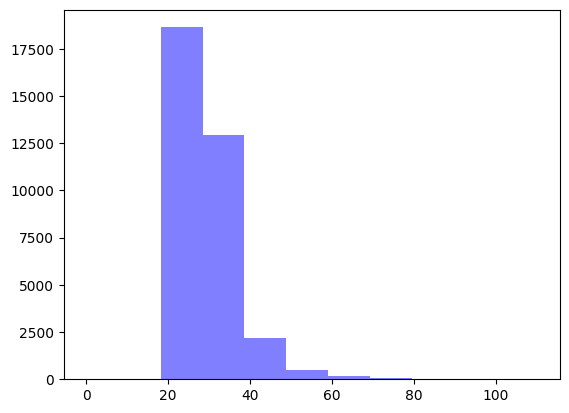

In [ ]:
yac_model = train_model(X, y, 29, 125)
yac_model = yac_model.to('cpu')

(array([0.00013818, 0.00011864, 0.00013705, 0.00012932, 0.00028136,
        0.08160432, 0.06875295, 0.04257091, 0.01421545, 0.01932455]),
 array([-25. , -20.6, -16.2, -11.8,  -7.4,  -3. ,   1.4,   5.8,  10.2,
         14.6,  19. ]),
 <BarContainer object of 10 artists>)

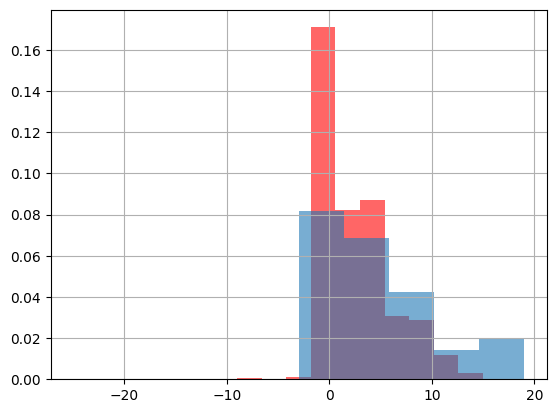

In [ ]:
n = 9
ydl = data.loc[data.yardline_100==n]
(ydl['yac_25'] - 25).hist(density=True, alpha=0.6, color='r')
test_x = torch.Tensor(ydl.sample(100)[yac_cols].values)
res = yac_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp(torch.multinomial(res,10000,replacement=True).reshape(-1), max= (n+35)) - 25
plt.hist(samples,density=True, alpha=0.6)

In [ ]:
model_path = "models/yac.pt"
torch.save(yac_model.state_dict(), model_path)


feature_config = {
    'yac_cols':yac_cols,
    'yac_path': 'models/yac.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

In [ ]:
pbp['desc'].sample(15)

635637    (2:00) (Shotgun) 1-K.Murray pass incomplete de...
491196    (3:42) (Shotgun) 6-J.Luton pass short right to...
392953    (12:15) 22-W.Gallman up the middle to NYG 37 f...
353716    (5:56) (Shotgun) 4-D.Carr pass short right to ...
613400    (10:38) 20-T.Pollard right tackle to NYG 1 for...
226613    (8:44) 26-L.Bell right guard to PIT 26 for -3 ...
78764     (12:06) (Shotgun) 35-L.Ball right guard to DEN...
92651     (:47) (Shotgun) 11-Alex Smith pass incomplete ...
80493     (13:11) (Shotgun) 2-M.Ryan pass short middle t...
372040    (14:07) (No Huddle) 10-E.Manning pass incomple...
69803     (15:00) 35-L.Ball up the middle to DEN 25 for ...
90530     (5:37) (No Huddle) 7-B.Roethlisberger pass inc...
357546    (1:21) (No Huddle, Shotgun) 9-M.Stafford pass ...
98704     (1:47) (Run formation) 28-A.Peterson up the mi...
590753    (4:43) 20-T.Pollard right tackle to MIN 16 for...
Name: desc, dtype: object

In [ ]:
pbp.iloc[177294].dropna().to_dict()

{'play_id': 2570.0,
 'game_id': '2013_13_TB_CAR',
 'old_game_id': '2013120100',
 'home_team': 'CAR',
 'away_team': 'TB',
 'season_type': 'REG',
 'week': 13,
 'posteam': 'CAR',
 'posteam_type': 'home',
 'defteam': 'TB',
 'game_date': '2013-12-01',
 'quarter_seconds_remaining': 0.0,
 'half_seconds_remaining': 900.0,
 'game_seconds_remaining': 900.0,
 'game_half': 'Half2',
 'quarter_end': 1.0,
 'drive': 18.0,
 'sp': 0.0,
 'qtr': 3.0,
 'goal_to_go': 0,
 'time': '00:00',
 'yrdln': 'CAR 35',
 'ydstogo': 0.0,
 'ydsnet': 66.0,
 'desc': 'END QUARTER 3',
 'shotgun': 0.0,
 'no_huddle': 0.0,
 'qb_kneel': 0.0,
 'qb_spike': 0.0,
 'qb_scramble': 0.0,
 'home_timeouts_remaining': 3.0,
 'away_timeouts_remaining': 3.0,
 'posteam_timeouts_remaining': 3.0,
 'defteam_timeouts_remaining': 3.0,
 'total_home_score': 24.0,
 'total_away_score': 6.0,
 'posteam_score': 24.0,
 'defteam_score': 6.0,
 'score_differential': 18.0,
 'posteam_score_post': 24.0,
 'defteam_score_post': 6.0,
 'score_differential_post': 18.0